# 1. Quá trình dự báo trên mô hình LR

## Thêm thư viện

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller


from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

## Nạp dữ liệu từ file csv

In [4]:
df = pd.read_csv('btc.csv', parse_dates=True,
                 index_col=0).drop(columns=['Open', 'High', 'Low', 'Volume', 'Currency'])
df

,Close
Date,
2020-06-01,1.01893
2020-06-02,0.95276
2020-06-03,0.96672
2020-06-04,0.97944
2020-06-05,0.96312
...,...
2022-05-28,2.90271
2022-05-29,2.94652
2022-05-30,3.17233


In [5]:
df['Timestamp'] = pd.to_datetime(df.index).astype(np.int64) / 10**9
df_index = df.index
df_close = df['Close'].values.reshape(-1, 1)
df.head()

df

,Close,Timestamp
Date,,
2020-06-01,1.01893,1.590970e+09
2020-06-02,0.95276,1.591056e+09
2020-06-03,0.96672,1.591142e+09
2020-06-04,0.97944,1.591229e+09
2020-06-05,0.96312,1.591315e+09
...,...,...
2022-05-28,2.90271,1.653696e+09
2022-05-29,2.94652,1.653782e+09
2022-05-30,3.17233,1.653869e+09


## Chuẩn hóa dữ liệu

In [6]:
LR_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Close'] = LR_sc.fit_transform(df_close)
df_scaled

,Close,Timestamp
Date,,
2020-06-01,-1.526877,1.590970e+09
2020-06-02,-1.566503,1.591056e+09
2020-06-03,-1.558143,1.591142e+09
2020-06-04,-1.550526,1.591229e+09
2020-06-05,-1.560299,1.591315e+09
...,...,...
2022-05-28,-0.398775,1.653696e+09
2022-05-29,-0.372539,1.653782e+09
2022-05-30,-0.237313,1.653869e+09


## Vẽ đồ thị

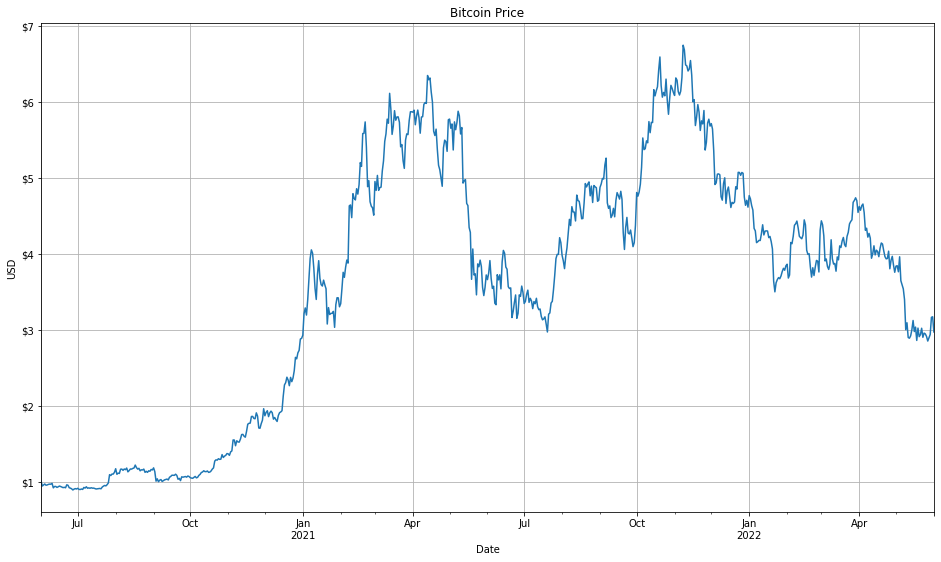

In [7]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [8]:
df

,Close,Timestamp
Date,,
2020-06-01,1.01893,1.590970e+09
2020-06-02,0.95276,1.591056e+09
2020-06-03,0.96672,1.591142e+09
2020-06-04,0.97944,1.591229e+09
2020-06-05,0.96312,1.591315e+09
...,...,...
2022-05-28,2.90271,1.653696e+09
2022-05-29,2.94652,1.653782e+09
2022-05-30,3.17233,1.653869e+09


## Chuẩn hóa dữ liệu

In [9]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values.reshape(-1, 1)


X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)


df_scaled = pd.DataFrame(index=df_index)
df_scaled['Timestamp'] = X_scaled
df_scaled['Close'] = y_scaled
df_scaled.head()


,Timestamp,Close
Date,,
2020-06-01,-1.729683,-1.526877
2020-06-02,-1.724944,-1.566503
2020-06-03,-1.720205,-1.558143
2020-06-04,-1.715466,-1.550526
2020-06-05,-1.710728,-1.560299


## Chia tập dữ liệu

In [10]:
interrupt = int(len(df_scaled) * .8)
interrupt


584

In [11]:
train_data, test_data = df_scaled[:interrupt], df_scaled[interrupt:]
index_test = df_scaled.index[interrupt:]
print(train_data.shape)
print(test_data.shape)


(584, 2)
(147, 2)


In [12]:
train_data.tail()

,Timestamp,Close
Date,,
2022-01-01,1.014116,0.721728
2022-01-02,1.018854,0.696205
2022-01-03,1.023593,0.643410
2022-01-04,1.028332,0.607905
2022-01-05,1.033071,0.463498


In [13]:
test_data.head()

,Timestamp,Close
Date,,
2022-01-06,1.037810,0.443832
2022-01-07,1.042549,0.350962
2022-01-08,1.047288,0.358465
2022-01-09,1.052026,0.369023
2022-01-10,1.056765,0.368059


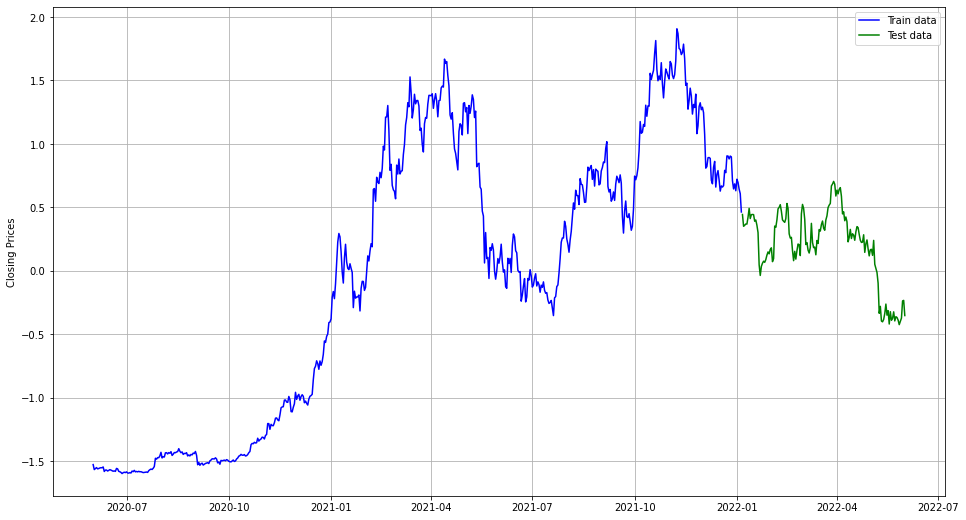

In [14]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(train_data['Close'], 'blue', label='Train data')
plt.plot(test_data['Close'], 'green', label='Test data')
plt.legend()




*   Gọi biến X <- Timestamp
*   Gọi biến y <- Close




In [15]:
X_train = train_data['Timestamp'].values.reshape(-1, 1)
y_train = train_data['Close'].values.reshape(-1, 1)

X_test = test_data['Timestamp'].values.reshape(-1, 1)
y_test = test_data['Close'].values.reshape(-1, 1)


In [16]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(X_train,y_train)
pred = LR_model.predict(X_test)

In [17]:
inv_pred = y_sc.inverse_transform(pred.reshape(-1, 1))
inv_test = y_sc.inverse_transform(y_test.reshape(-1, 1))

## Vẽ đồ thị cho tập test và kết quả dự đoán

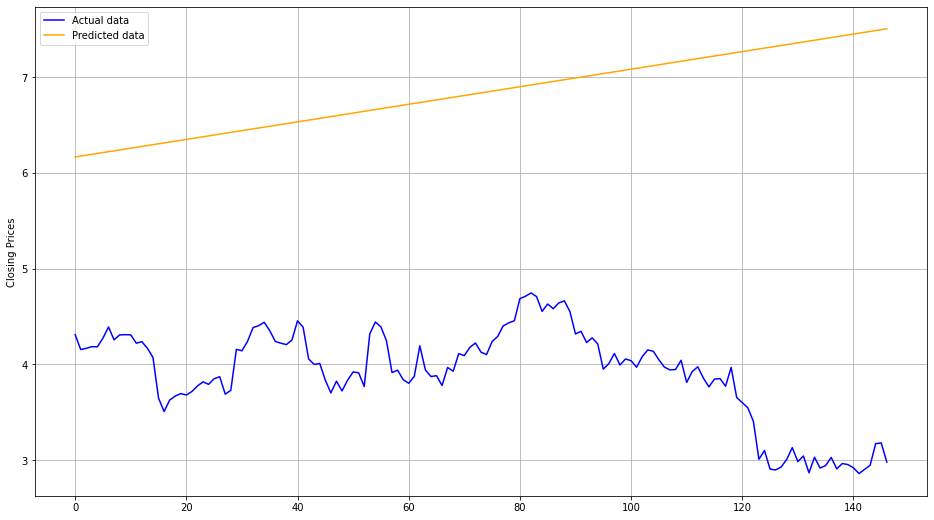

In [18]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'orange', label='Predicted data')
plt.legend()


In [19]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 2.93
MAPE: 78.98%
MSE: 9.18
RMSE: 3.03
R2: -37.82


## Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình LR

In [20]:
df_pred = pd.DataFrame(columns=['Actual', 'Pred', 'Error'], index=index_test)
df_pred['Actual'] = column_or_1d(inv_test)
df_pred['Pred'] = column_or_1d(inv_pred)
df_pred['Error'] = df_pred['Actual'] - df_pred['Pred']
df_pred

,Actual,Pred,Error
Date,,,
2022-01-06,4.30975,6.164448,-1.854698
2022-01-07,4.15467,6.173611,-2.018941
2022-01-08,4.16720,6.182775,-2.015575
2022-01-09,4.18483,6.191938,-2.007108
2022-01-10,4.18322,6.201102,-2.017882
...,...,...,...
2022-05-28,2.90271,7.465655,-4.562945
2022-05-29,2.94652,7.474818,-4.528298
2022-05-30,3.17233,7.483982,-4.311652


# 2. Quá trình dự đoán trên mô hình LSTM

## Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [21]:
df_lstm = df_pred.copy()
df_lstm

,Actual,Pred,Error
Date,,,
2022-01-06,4.30975,6.164448,-1.854698
2022-01-07,4.15467,6.173611,-2.018941
2022-01-08,4.16720,6.182775,-2.015575
2022-01-09,4.18483,6.191938,-2.007108
2022-01-10,4.18322,6.201102,-2.017882
...,...,...,...
2022-05-28,2.90271,7.465655,-4.562945
2022-05-29,2.94652,7.474818,-4.528298
2022-05-30,3.17233,7.483982,-4.311652


## Vẽ đồ thị thể hiện sai số

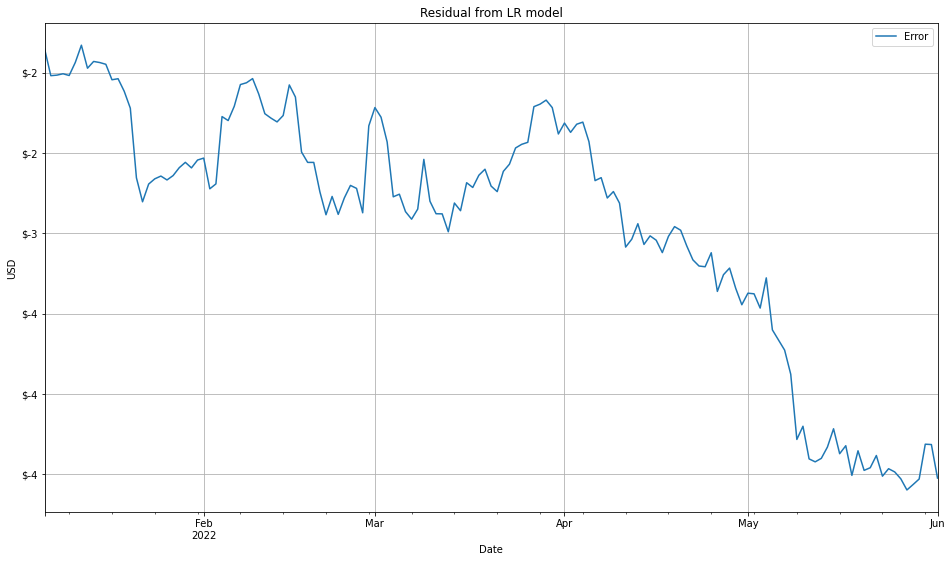

In [22]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from LR model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [23]:
error = np.array(error)
error

array([[-1.85469779],
       [-2.01894122],
       [-2.01557464],
       [-2.00710807],
       [-2.0178815 ],
       [-1.93694493],
       [-1.82932836],
       [-1.97259179],
       [-1.93042522],
       [-1.93721864],
       [-1.94817207],
       [-2.0443155 ],
       [-2.03794893],
       [-2.11579236],
       [-2.22114579],
       [-2.65434922],
       [-2.80354264],
       [-2.69327607],
       [-2.6607595 ],
       [-2.64349293],
       [-2.66767636],
       [-2.64044979],
       [-2.59153322],
       [-2.55812664],
       [-2.59260007],
       [-2.5436735 ],
       [-2.53172693],
       [-2.72284036],
       [-2.69224379],
       [-2.27342722],
       [-2.29814064],
       [-2.20929407],
       [-2.0742875 ],
       [-2.06302093],
       [-2.03711436],
       [-2.13306779],
       [-2.25549122],
       [-2.28297464],
       [-2.30654807],
       [-2.2667915 ],
       [-2.07654493],
       [-2.15178836],
       [-2.49403179],
       [-2.55846522],
       [-2.55860864],
       [-2

In [24]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (144, 3, 1)
y_train (144, 1)


In [25]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("bitcoin.h5")

Epoch 1/300
5/5 [==============================] - 3s 8ms/step - loss: 9.1246
Epoch 2/300
5/5 [==============================] - 0s 6ms/step - loss: 8.6827
Epoch 3/300
5/5 [==============================] - 0s 5ms/step - loss: 8.2220
Epoch 4/300
5/5 [==============================] - 0s 6ms/step - loss: 7.6190
Epoch 5/300
5/5 [==============================] - 0s 7ms/step - loss: 6.8586
Epoch 6/300
5/5 [==============================] - 0s 6ms/step - loss: 5.8039
Epoch 7/300
5/5 [==============================] - 0s 5ms/step - loss: 4.3681
Epoch 8/300
5/5 [==============================] - 0s 5ms/step - loss: 2.5268
Epoch 9/300
5/5 [==============================] - 0s 5ms/step - loss: 0.7600
Epoch 10/300
5/5 [==============================] - 0s 5ms/step - loss: 0.6664
Epoch 11/300
5/5 [==============================] - 0s 5ms/step - loss: 0.6706
Epoch 12/300
5/5 [==============================] - 0s 5ms/step - loss: 0.3454
Epoch 13/300
5/5 [==============================] - 0s 6ms/st

In [26]:
model = load_model("bitcoin.h5")
error_pred = model.predict(x_train)
error_pred

array([[-2.058823 ],
       [-2.1182616],
       [-2.1165142],
       [-2.102326 ],
       [-2.0657578],
       [-2.0306134],
       [-2.0222924],
       [-2.065435 ],
       [-2.0533822],
       [-2.0753405],
       [-2.104761 ],
       [-2.1529486],
       [-2.1906655],
       [-2.3281488],
       [-2.5242724],
       [-2.726829 ],
       [-2.7492552],
       [-2.6898942],
       [-2.6758065],
       [-2.6707206],
       [-2.663072 ],
       [-2.630627 ],
       [-2.6070302],
       [-2.594337 ],
       [-2.591542 ],
       [-2.604272 ],
       [-2.651055 ],
       [-2.640422 ],
       [-2.5075567],
       [-2.3316433],
       [-2.2916224],
       [-2.2170055],
       [-2.1576207],
       [-2.1628592],
       [-2.201231 ],
       [-2.2778113],
       [-2.3378427],
       [-2.3482316],
       [-2.3117096],
       [-2.2555716],
       [-2.2641134],
       [-2.4037125],
       [-2.5607479],
       [-2.6219733],
       [-2.7049453],
       [-2.8033173],
       [-2.8507562],
       [-2.81

In [27]:
df_lstm

,Actual,Pred,Error
Date,,,
2022-01-06,4.30975,6.164448,-1.854698
2022-01-07,4.15467,6.173611,-2.018941
2022-01-08,4.16720,6.182775,-2.015575
2022-01-09,4.18483,6.191938,-2.007108
2022-01-10,4.18322,6.201102,-2.017882
...,...,...,...
2022-05-28,2.90271,7.465655,-4.562945
2022-05-29,2.94652,7.474818,-4.528298
2022-05-30,3.17233,7.483982,-4.311652


In [28]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,Pred,Error,Error Prediction
Date,,,,
2022-01-06,4.30975,6.164448,-1.854698,-2.058823
2022-01-07,4.15467,6.173611,-2.018941,-2.118262
2022-01-08,4.16720,6.182775,-2.015575,-2.116514
2022-01-09,4.18483,6.191938,-2.007108,-2.102326
2022-01-10,4.18322,6.201102,-2.017882,-2.065758
...,...,...,...,...
2022-05-25,2.95406,7.438164,-4.484104,-4.593006
2022-05-26,2.92035,7.447328,-4.526978,-4.632883
2022-05-27,2.86012,7.456491,-4.596371,-4.647637


In [29]:
df_lstm['LR_LSTM'] = df_lstm['Pred'] + df_lstm['Error Prediction']
df_lstm

,Actual,Pred,Error,Error Prediction,LR_LSTM
Date,,,,,
2022-01-06,4.30975,6.164448,-1.854698,-2.058823,4.105625
2022-01-07,4.15467,6.173611,-2.018941,-2.118262,4.055350
2022-01-08,4.16720,6.182775,-2.015575,-2.116514,4.066260
2022-01-09,4.18483,6.191938,-2.007108,-2.102326,4.089612
2022-01-10,4.18322,6.201102,-2.017882,-2.065758,4.135344
...,...,...,...,...,...
2022-05-25,2.95406,7.438164,-4.484104,-4.593006,2.845158
2022-05-26,2.92035,7.447328,-4.526978,-4.632883,2.814445
2022-05-27,2.86012,7.456491,-4.596371,-4.647637,2.808854


## Vẽ đồ thị

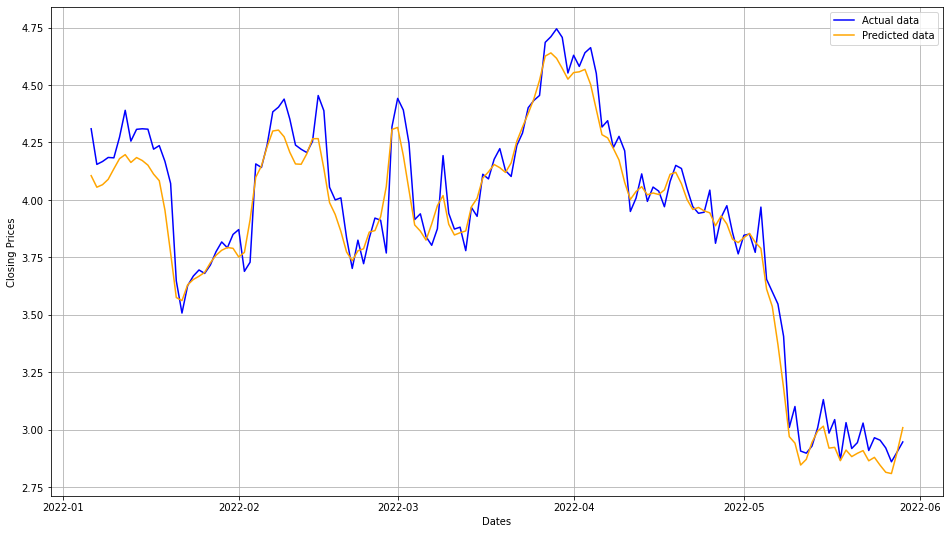

In [30]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['LR_LSTM'], 'orange', label='Predicted data')
plt.legend()

## Đánh giá mô hình

In [31]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(df_lstm.Actual, df_lstm.LR_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.LR_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.LR_LSTM)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.07
MAPE: 1.90%
MSE: 0.01
RMSE: 0.10
R2: -37.82


## Lấy 3 ngày cuối ra để dự báo

In [32]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -4.596371
2022-05-28   -4.562945
2022-05-29   -4.528298
Name: Error, dtype: float64

## Đưa về ma trận

In [33]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-4.59637121],
        [-4.56294464],
        [-4.52829807]]])

In [34]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

array([-4.647637], dtype=float32)

## So sánh kết quả dự đoán với giá trị thực

In [35]:
y_LR = df_pred.copy()
y_LR = y_LR.tail(4).head(1)
y_LR

,Actual,Pred,Error
Date,,,
2022-05-29,2.94652,7.474818,-4.528298


In [36]:
y_LR['Final_LSTM'] = y_LR.Pred + y_forecast
y_LR

,Actual,Pred,Error,Final_LSTM
Date,,,,
2022-05-29,2.94652,7.474818,-4.528298,2.827181


## Ghi ra file csv

In [37]:
df.to_csv("processed_data.csv")
df_scaled.to_csv("scaled_data.csv")
df_pred.to_csv("LR-PRED.csv")
df_lstm.to_csv("LSTM_PRED.csv")
y_LR.to_csv("Forecast.csv")